This notebook implements DBA K-Means clustering on multivariate time series data for Human Activity Recognition. The core of this approach lies in using Dynamic Time Warping (DTW) as the distance metric, with DTW Barycenter Averaging (DBA) used to compute the cluster centroids (or barycenters).The notebook proceeds through the following steps:
1. Data Loading and Preprocessing: Loads the raw time series data (X) and labels (y), and applies Z-normalization to each individual time series to remove amplitude and offset biases, which is essential for shape-based clustering like DBA K-Means.
2. Clustering Execution: Runs the run_dba_kmeans function, utilizing the tslearn library to perform $k$-means with DTW/DBA.
3. Evaluation: Computes standard external (ARI, NMI, Purity) and internal (DTW Silhouette) metrics to assess clustering quality.
4. Visualization and Interpretation: Uses t-SNE on the precomputed DTW distance matrix to visualize the data in 2D, and plots the confusion matrix (aligned using the Hungarian algorithm) and cluster centroids for analysis.
5. Grid Search: Explores the influence of hyperparameters.

1. Import Libraries

In [ ]:
import sys; sys.path.append("..")
import numpy as np
from src.io import load_dataset
from src.preprocess import z_norm_per_series
from src.cluster_dba import run_dba_kmeans, _to_tslearn_shape
from src.eval import external_scores, silhouette_by_metric, confusion_with_hungarian
from src.utils_io import save_clustering_results 
from src.viz import embed_tsne_from_dist, scatter_2d
from src.viz import plot_confusion_matrix
from src.distances import dtw_distance_matrix
import time
from itertools import product

2. Load Data and Apply Z-Normalization

In [2]:
# Load dataset
X_train, X_test, y_train, y_test = load_dataset("../data/raw", test_size=0.2, random_state=42)

# Preprocessing: z-normalization (per series)
Xn_train = z_norm_per_series(X_train)
Xn_test  = z_norm_per_series(X_test)

3. Define Hyperparameters

In [3]:
N_CLUSTERS=6
N_INIT=25
MAX_ITER=50
RANDOM_STATE=42
SAKOE_CHIBA_RADIUS=20

4. Execute DBA k-means Clustering

In [4]:
# --- Clustering: DBA-k-means (DTW) ---
y_pred, model, centers = run_dba_kmeans(
    Xn_train, 
    n_clusters=N_CLUSTERS,
    n_init=N_INIT,
    max_iter=MAX_ITER,
    random_state=RANDOM_STATE,
    metric_params={"sakoe_chiba_radius": SAKOE_CHIBA_RADIUS},  
    verbose=False
)

5. Evaluate clustering metrics

In [ ]:
#external metrics on train 
scores = external_scores(y_train, y_pred)
print("External metrics (train):", scores)

External metrics (train): {'ARI': 0.5195809062436747, 'NMI': np.float64(0.6933603234181873), 'Purity': np.float64(0.6173285198555957)}


In [6]:
# Align clusters to labels (Hungarian) and show confusion 
y_pred_mapped, C, mapping = confusion_with_hungarian(y_train, y_pred)
mapping_clean = {int(k): int(v) for k, v in mapping.items()}
print("Cluster->Label mapping:", mapping_clean)

Cluster->Label mapping: {1: 1, 3: 2, 2: 3, 5: 4, 4: 5, 0: 6}


In [7]:
#get unique labels
true_labels = np.sort(np.unique(y_train))
pred_labels = np.sort(np.unique(y_pred))

In [8]:
Xts = _to_tslearn_shape(Xn_train)
D = dtw_distance_matrix(Xts, sakoe_chiba_radius=5)
X2 = embed_tsne_from_dist(D, perplexity=30, random_state=42)

In [9]:
# Silhouette with DTW (train) 
sil = silhouette_by_metric(D, y_pred, metric="precomputed")
print(f"DTW Silhouette (train): {sil:.3f}")

DTW Silhouette (train): 0.047


6. Save Results and Summarize Run Parameters

In [ ]:
params = {
    "n_clusters": N_CLUSTERS, 
    "n_init":  N_INIT, 
    "max_iter": MAX_ITER,
    "random_state": RANDOM_STATE, 
    "sakoe_chiba_radius": SAKOE_CHIBA_RADIUS, 
    "metric": "dtw"
}

root, arr_dir, fig_dir, run_id = save_clustering_results(
    method_name="dba_kmeans",
    y_pred=y_pred,
    y_true=y_train,
    scores={**scores, "Silhouette_DTW": float(sil)},
    centers=centers,
    mapping=mapping_clean,
    embedding_2d=X2,
    dist_matrix=D,
    confusion=C,
    labels_true=true_labels,
    labels_pred=pred_labels,
    params=params,
    output_dir="../results",
    run_id=None 
)

✅ Saved run to: ../results\dba_kmeans\2025-11-11_13-26-50_seed42


7. Visualization

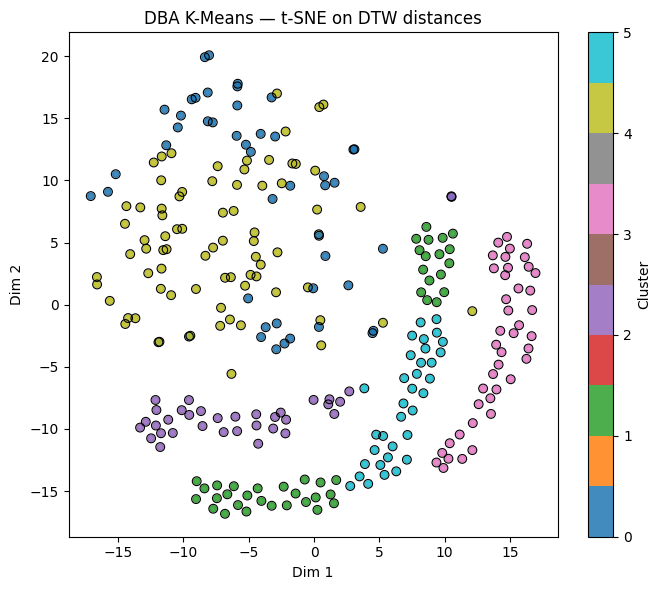

In [13]:
fig = scatter_2d(X2, y_pred, title="DBA K-Means — t-SNE on DTW distances", y_true=y_train, show=True)

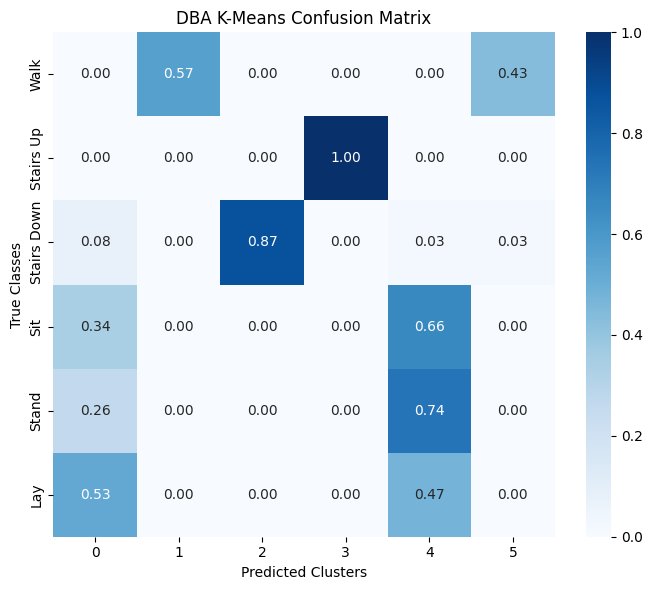

In [14]:
fig = plot_confusion_matrix(
    C, true_labels, pred_labels,
    label_to_activity={1:"Walk",2:"Stairs Up",3:"Stairs Down",4:"Sit",5:"Stand",6:"Lay"},
    normalize=True,
    title="DBA K-Means Confusion Matrix",
    show=True
)

8. Grid Search for Optimal hyperparameters

--> k=6 | n_init=25 | max_iter=50 | max_iter_barycenter=50 | r=15 | seed=42
✅ Saved run to: ../results\dba_kmeans_3\2025-11-12_15-03-44_seed42


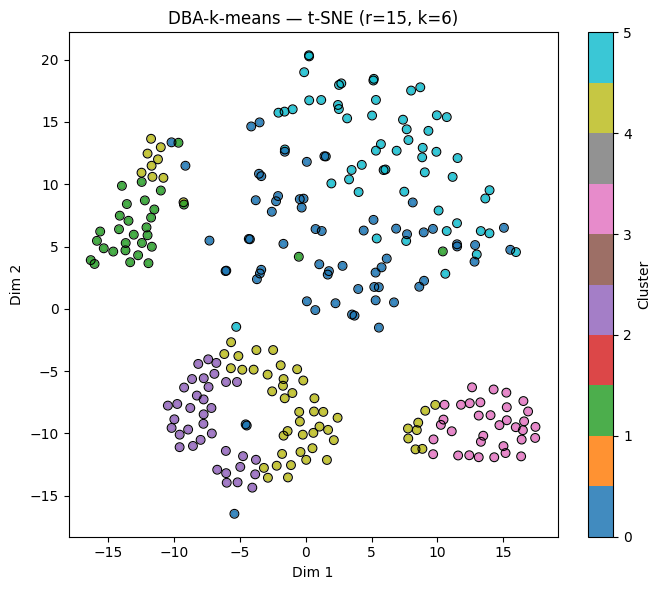

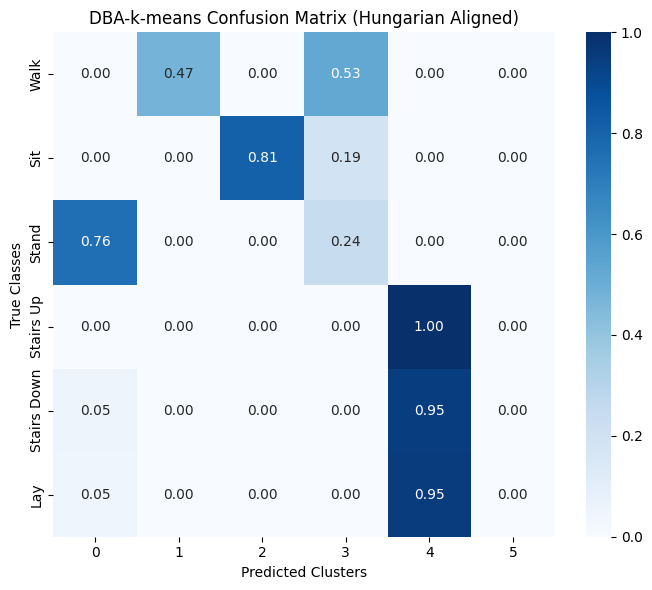

ARI=0.416  NMI=0.603  Sil=0.102  time=1763.2s   -> 2025-11-12_15-03-44_seed42
--> k=6 | n_init=25 | max_iter=50 | max_iter_barycenter=50 | r=20 | seed=42
✅ Saved run to: ../results\dba_kmeans_3\2025-11-12_15-15-28_seed42


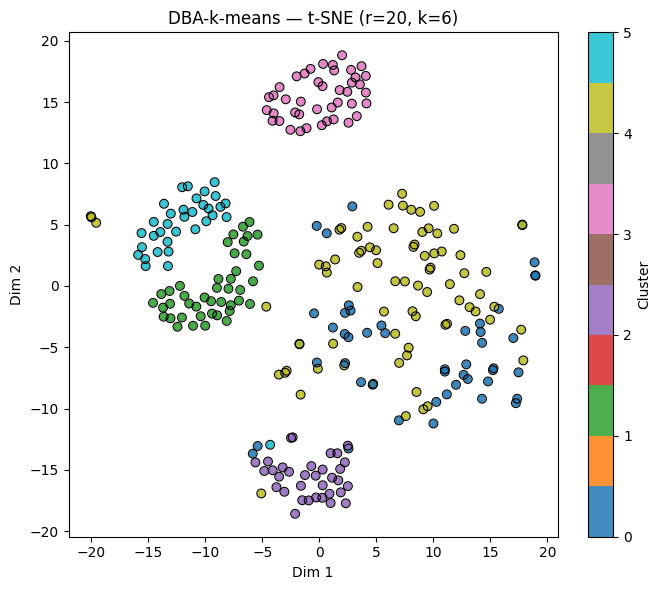

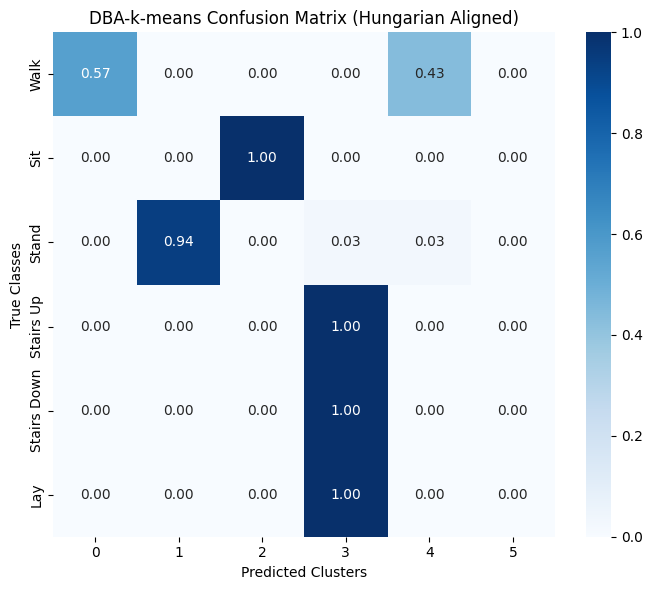

ARI=0.520  NMI=0.693  Sil=0.110  time=703.5s   -> 2025-11-12_15-15-28_seed42


,n_clusters,n_init,max_iter,max_iter_barycenter,random_state,sakoe_chiba_radius,metric,ARI,NMI,Purity,Silhouette_DTW,time_sec,run_dir
1,6,25,50,50,42,20,dtw,0.519581,0.693360,0.617329,0.110276,703.539060,../results\dba_kmeans_3\2025-11-12_15-15-28_se...
0,6,25,50,50,42,15,dtw,0.415831,0.602889,0.523466,0.101885,1763.208707,../results\dba_kmeans_3\2025-11-12_15-03-44_se...


In [ ]:
#CONFIG
RESULTS_DIR = "../results"
METHOD_NAME = "dba_kmeans_3"

#Hyperparameter grid
N_CLUSTERS_LIST        = [6]         
N_INIT_LIST            = [25]     
MAX_ITER_LIST          = [50]        
MAX_ITER_BARYCENTER_LIST = [50] 
RADIUS_LIST            = [15, 20] 
RANDOM_SEEDS           = [42]      

#Options calcul
COMPUTE_EMBEDDING = True       
SAVE_FIGURES      = True      
SUBSAMPLE_RATIO   = 1.0       

#Preprocessing: z-normalization (per series)
Xn_train = z_norm_per_series(X_train)
ytrue = y_train.copy()

#Subsample optionnel
if SUBSAMPLE_RATIO < 1.0:
    rng = np.random.default_rng(0)
    idx = rng.choice(len(ytrue), size=int(len(ytrue)*SUBSAMPLE_RATIO), replace=False)
    Xn_train = Xn_train[idx]
    ytrue    = ytrue[idx]


#Helper function 
def run_one(n_clusters, n_init, max_iter, max_iter_barycenter, radius, seed):
    t0 = time.time()

    # Clustering
    y_pred, model, centers = run_dba_kmeans(
        Xn_train,
        n_clusters=n_clusters,
        n_init=n_init,
        max_iter=max_iter,
        random_state=seed,
        metric_params={"sakoe_chiba_radius": radius},
        verbose=False
    )

    if hasattr(model, "max_iter_barycenter"):
        model.max_iter_barycenter = max_iter_barycenter

    # Evaluations
    Xts = _to_tslearn_shape(Xn_train)
    sil = silhouette_by_metric(Xts, y_pred, sakoe_chiba_radius=radius, metric="dtw")
    scores = external_scores(ytrue, y_pred)
    scores["Silhouette_DTW"] = float(sil)

    # Mapping & confusion
    y_pred_mapped, C, mapping = confusion_with_hungarian(ytrue, y_pred)
    mapping_clean = {int(k): int(v) for k, v in mapping.items()}

    # Distances + 2D embedding  
    D = X2 = None
    if COMPUTE_EMBEDDING:
        D  = dtw_distance_matrix(Xts, sakoe_chiba_radius=radius)
        X2 = embed_tsne_from_dist(D, perplexity=30, random_state=seed)

    params = {
        "n_clusters": n_clusters,
        "n_init": n_init,
        "max_iter": max_iter,
        "max_iter_barycenter": max_iter_barycenter, 
        "random_state": seed,
        "sakoe_chiba_radius": radius,
        "metric": "dtw",
    }

    #Save
    root, arr_dir, fig_dir, run_id = save_clustering_results(
        method_name=METHOD_NAME,
        y_pred=y_pred,
        y_true=ytrue,
        scores=scores,
        centers=centers,
        mapping=mapping_clean,
        embedding_2d=X2,
        dist_matrix=D,
        confusion=C,
        labels_true=np.sort(np.unique(ytrue)),
        labels_pred=np.sort(np.unique(y_pred)),
        params=params,
        output_dir=RESULTS_DIR,
        run_id=None
    )

    #Figures 
    if SAVE_FIGURES and X2 is not None:
        import matplotlib.pyplot as plt
        fig = scatter_2d(X2, y_pred, title=f"DBA-k-means — t-SNE (r={radius}, k={n_clusters})", y_true=ytrue, show=True)
        fig.savefig(f"{fig_dir}/scatter_tsne.png", dpi=150)
        plt.close(fig)

        fig = plot_confusion_matrix(
            C,
            labels_true=np.sort(np.unique(ytrue)),
            labels_pred=np.sort(np.unique(y_pred)),
            label_to_activity={1:"Walk",2:"Sit",3:"Stand",4:"Stairs Up",5:"Stairs Down",6:"Lay"},
            normalize=True,
            title="DBA-k-means Confusion Matrix (Hungarian Aligned)",
            show=True
        )
        fig.savefig(f"{fig_dir}/confusion_matrix_norm.png", dpi=150)
        plt.close(fig)

    elapsed = time.time() - t0
    return {
        "run_dir": root,
        "run_id": run_id,
        "params": params,
        "scores": scores,
        "time_sec": elapsed
    }

#Main grid loop
results = []
for n_clusters, n_init, max_iter, max_iter_barycenter, radius, seed in product(
    N_CLUSTERS_LIST,
    N_INIT_LIST,
    MAX_ITER_LIST,
    MAX_ITER_BARYCENTER_LIST,
    RADIUS_LIST,
    RANDOM_SEEDS
):
    print(f"--> k={n_clusters} | n_init={n_init} | max_iter={max_iter} | max_iter_barycenter={max_iter_barycenter} | r={radius} | seed={seed}")
    out = run_one(n_clusters, n_init, max_iter, max_iter_barycenter, radius, seed)
    results.append(out)
    print(f"ARI={out['scores']['ARI']:.3f}  NMI={out['scores']['NMI']:.3f}  Sil={out['scores']['Silhouette_DTW']:.3f}  time={out['time_sec']:.1f}s   -> {out['run_id']}")

#Summary
try:
    import pandas as pd
    rows = []
    for r in results:
        row = {**r["params"], **r["scores"], "time_sec": r["time_sec"], "run_dir": r["run_dir"]}
        rows.append(row)
    df = pd.DataFrame(rows).sort_values(["ARI","NMI","Silhouette_DTW"], ascending=False)
    display(df)
except Exception:
    print("Install pandas to get a sortable summary table.")
